# Configs

In [6]:
import json
import time
import torch
import pprint
import mdtraj
import random
import pandas
import nglview
import numpy as np
import matplotlib.pyplot as plt

from openmm import *
from tqdm.auto import tqdm
from matplotlib import animation 
from openmm.app import *
from openmm.unit import *
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

import jax.numpy as jnp
from jax import grad, value_and_grad, vmap


In [7]:
molecule = "alanine"
temperature = "273.0"
state = "c5"

result_dir = f"../log/{molecule}/{temperature}/{state}"
pdb_file = f"../data/{molecule}/{state}.pdb"

In [8]:
arg_file = f"{result_dir}/args.json"

with open(arg_file, 'r') as f:
	arg_data = json.load(f)
 
pprint.pprint(arg_data)

{'config': 'config/alanine/debug.json',
 'force_field': 'amber99',
 'freq_csv': 1000,
 'freq_dcd': 1,
 'freq_stdout': 10000,
 'log_csv': True,
 'log_dcd': True,
 'log_stdout': False,
 'molecule': 'alanine',
 'platform': 'OpenCL',
 'precision': 'mixed',
 'solvent': 'tip3p',
 'state': 'c5',
 'temperature': 273.0,
 'time': 100}


# Trajectory from simulation

In [22]:
start = time.time()
print("Loading trajectory...")
loaded_traj = mdtraj.load(
    f"{result_dir}/traj.dcd",
    top=pdb_file
)
end = time.time()
print(f"{end-start} seconds")
print("Trajectory loaded.!!")

Loading trajectory...
0.005322694778442383 seconds
Trajectory loaded.!!


In [27]:
def plot_ram_from_sim(loaded_traj, pdb_file, state):
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(6,6))
    phis = mdtraj.compute_phi(loaded_traj)[1].ravel()
    psis = mdtraj.compute_psi(loaded_traj)[1].ravel()
    
    state_traj = mdtraj.load(pdb_file)
    phi_start = mdtraj.compute_phi(state_traj)[1].ravel()
    psi_start = mdtraj.compute_psi(state_traj)[1].ravel()
    ax.set_title(f"State {state}")
    ax.scatter(phi_start * 180 / np.pi, psi_start * 180 / np.pi, c='red', s=100, zorder=1)
    
    # Ramachandran plot
    # ax.hist2d(phis * 180 / np.pi, psis * 180 / np.pi, 100, norm=LogNorm(), zorder=0)
    ax.scatter(phis * 180 / np.pi, psis * 180 / np.pi, s=100)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xticks(np.linspace(-180, 180, 5))
    ax.set_yticks(np.linspace(-180, 180, 5))
    ax.set_xlabel("Phi [deg]")
    ax.set_ylabel("Psi [deg]")
    fig.tight_layout()

<Figure size 640x480 with 0 Axes>

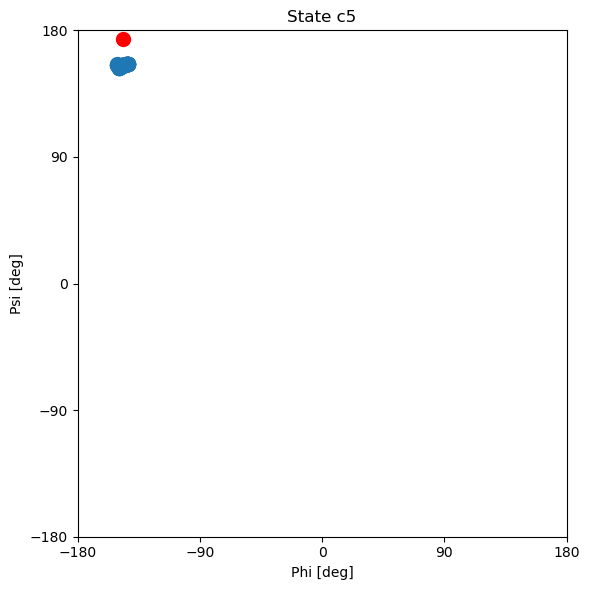

In [28]:
plot_ram_from_sim(loaded_traj, pdb_file, state)

# Trajectory from dataset

In [13]:

from torch.utils.data import Dataset

class MD_Dataset(Dataset):
    def __init__(self, traj, config):
        self.molecule = config['molecule']
        self.state = config['state']
        self.temperature = config['temperature']
        self.time = config['time']
        self.force_field = config['force_field']
        self.solvent = config['solvent']
        self.platform = config['platform']
        self.precision = config['precision']
        
        data_x_list = []
        data_y_list = []
        for t in tqdm(
            range(self.time -1),
            desc="Loading data"
        ):
            current_state = torch.tensor(loaded_traj[t].xyz.squeeze())
            next_state = torch.tensor(loaded_traj[t+1].xyz.squeeze())
            data_x_list.append(current_state)
            data_y_list.append(next_state)
        self.x = torch.stack(data_x_list)
        self.y = torch.stack(data_y_list)
        
        self.sanity_check(loaded_traj)
    
    def sanity_check(self, loaded_traj):
        print("Running sanity check...")
        print(f">> x size: {self.x.shape}")
        print(f">> y size: {self.y.shape}")
        assert torch.equal(x.shape, y.shape), f"Shape of x and y not equal"
        
        for t in tqdm(
            range(self.time -1),
            desc="Sanity check"
        ):
            x = self.x[t]
            y = self.y[t]
            x_frame = torch.tensor(loaded_traj[t].xyz.squeeze())
            y_frame = torch.tensor(loaded_traj[t+1].xyz.squeeze())
            
            assert torch.equal(x, x_frame), f"Frame {t}, x not equal"
            assert torch.equal(y, y_frame), f"Frame {t+1}, y not equal"        
            

    def __getitem__(self, index):
	    return self.x[index], self.y[index]
 
    def __len__(self):
	    return self.x.shape[0]

In [14]:
dataset_dir = f"../dataset/{molecule}/{temperature}"
data = torch.load(f"{dataset_dir}/c5.pt")

frames = []
for t in tqdm(range(data.time - 1)):
    x, y = data[t]
    frames.append(x)
    
print(len(frames))
print(frames[0].shape)

  0%|          | 0/99 [00:00<?, ?it/s]

99
torch.Size([22, 3])


In [29]:
angle_1 = [6, 8, 14, 16]
angle_2 = [4, 6, 8, 14]

def dihedral_old(i, j, k, l):
    b1, b2, b3 = j - i, k - j, l - k

    c1 = vmap(jnp.cross, (0, 0))(b2, b3)
    c2 = vmap(jnp.cross, (0, 0))(b1, b2)

    p1 = (b1 * c1).sum(-1)
    p1 = p1 * jnp.sqrt((b2 * b2).sum(-1))
    p2 = (c1 * c2).sum(-1)

    r = vmap(jnp.arctan2, (0, 0))(p1, p2)
    return r

def dihedral(p):
    """http://stackoverflow.com/q/20305272/1128289"""
    b = p[:-1] - p[1:]
    b[0] *= -1
    v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
    # Normalize vectors
    v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
    b1 = b[1] / np.linalg.norm(b[1])
    x = np.dot(v[0], v[1])
    m = np.cross(v[0], b1)
    y = np.dot(m, v[1])
    return np.arctan2(y, x)

In [30]:
def plot_ram_from_dataset(frames, pdb_file, state):
	fig = plt.figure()
	fig, ax = plt.subplots(figsize=(6,6))
	
	phis = []
	psis = []
	for frame in frames:
		psis.append(dihedral(np.array(frame[angle_1, :])) * 180 / np.pi)
		phis.append(dihedral(np.array(frame[angle_2,: ])) * 180 / np.pi)
	print(psis)
	print(phis)

	state_traj = mdtraj.load(pdb_file)
	phi_start = mdtraj.compute_phi(state_traj)[1].ravel()
	psi_start = mdtraj.compute_psi(state_traj)[1].ravel()
	ax.scatter(phi_start * 180 / np.pi, psi_start * 180 / np.pi, c='red', s=100, zorder=1)

	# Ramachandran plot
	# ax.hist2d(phis, psis, 100, norm=LogNorm(), zorder=0)
	ax.scatter(phis, psis, s=100)
	ax.set_xlim(-180, 180)
	ax.set_ylim(-180, 180)
	ax.set_xticks(np.linspace(-180, 180, 5))
	ax.set_yticks(np.linspace(-180, 180, 5))
	ax.set_xlabel("Phi [deg]")
	ax.set_ylabel("Psi [deg]")
	fig.tight_layout()

[156.0918840458105, 156.1049843486386, 156.1127024624007, 156.11689619855107, 156.17080005148082, 156.2209199796104, 156.27909953096056, 156.32187017554318, 156.3579882158742, 156.3872077651435, 156.39323199199146, 156.37274142448143, 156.3602421783003, 156.31079160870942, 156.236451829783, 156.18678269413866, 156.14947620089205, 156.10121408421674, 156.04606713685806, 155.97176833906667, 155.890789616267, 155.8127751955671, 155.76191760700718, 155.72584054781117, 155.68826084699776, 155.6811437898826, 155.66640424165374, 155.63835948492166, 155.61192665283372, 155.59649042530947, 155.5997415953544, 155.59978257648942, 155.60896235073392, 155.60692695436126, 155.6010393312967, 155.58258416015934, 155.55917027168454, 155.54570113864125, 155.511140381441, 155.47771343564295, 155.44286581049755, 155.4177580351086, 155.38672165552003, 155.37057508832214, 155.36800693719422, 155.36675018238694, 155.34464769023276, 155.34053591635242, 155.35449682301592, 155.37218701296626, 155.4053270908191

<Figure size 640x480 with 0 Axes>

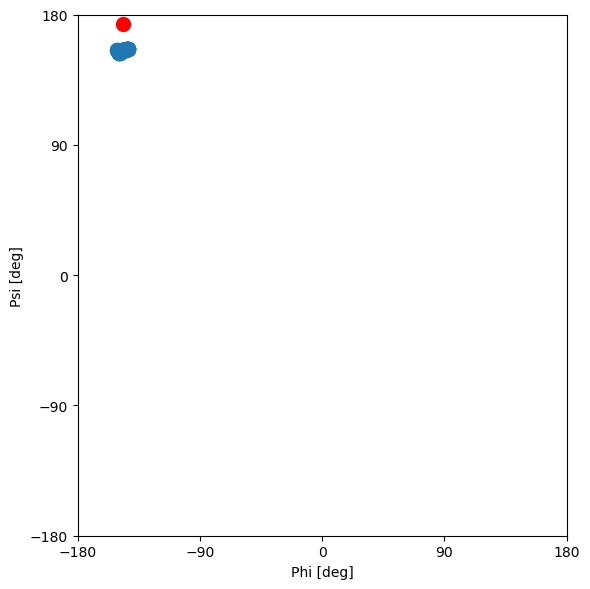

In [31]:
plot_ram_from_dataset(frames, pdb_file, state)